# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 2

Please use the following code to prepare the dataset.
 

In [30]:
from folktables.acs import adult_filter
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score,f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from scipy.stats import  pearsonr
import scipy
import seaborn as sns

DOWNLOAD = False

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=DOWNLOAD)


def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', 'RAC1P'],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

definition_df = data_source.get_definitions(download=DOWNLOAD)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)

# Drop the "redundant" columns
features = features.drop(["RAC1P_White alone", 
                          "SEX_Male", 
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm' ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)
        
features.head()

Columns with the protected features:
Column ID: 54 (SEX_Female)
Column ID: 55 (RAC1P_Black or African American alone)


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,21,20.0,52,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,65,8.0,33,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,33,40.0,53,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,18,18.0,106,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,27,50.0,23,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## The Task: 
Train three binary classifiers to predict income (label = True if income>$25k, otherwise label = False)

1. Train one classification model on the raw dataset and calculate its general 
accuracy, and respectively the accuracies for men and women and for 
different races. The model does not need to be fancy, logistic regression 
or Random Forest are completely fine choices. Remember to evaluate the 
model using cross validation.

In [31]:
seed = 42

In [32]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, labels, groups, test_size=0.3, random_state=seed, shuffle=True)

# Subsample for efficiency
N = 20000  # Subsample size

np.random.seed(seed)

# Generate random unique indices for subsampling
indices_train = np.random.choice(X_train.shape[0], N, replace=False)
indices_test = np.random.choice(X_test.shape[0], N, replace=False)

# Subsample using the random indices
### Train set
X_train = X_train.iloc[indices_train]
y_train = y_train.iloc[indices_train]
group_train = group_train.iloc[indices_train]
### Test set
X_test = X_test.iloc[indices_test]
y_test = y_test.iloc[indices_test]
group_test = group_test.iloc[indices_test]
group_test_dict = {
    'Males': group_test['SEX'] == 1,
    'Females': group_test['SEX'] == 2,
    'Whites': group_test['RAC1P'] == 1,
    'African-Americans': group_test['RAC1P'] == 2
}

In [33]:
# Subset for protected and non-protected features
X_train_p = X_train.iloc[:, -2:]
X_test_p = X_test.iloc[:, -2:]
X_train_np = X_train.iloc[:, :-2]
X_test_np = X_test.iloc[:, :-2]

## Should we train on the non-protected features only? Then group differences must be due to the correllations

In [34]:
def cross_acc(X_train):
    scaler = StandardScaler() ## We need to scale within the cross val step to avoid data leakage
    cls = LogisticRegression(penalty=None, max_iter=1000, random_state=seed)

    pipe = make_pipeline(scaler, cls)

    kfold = KFold(10, shuffle=True, random_state=seed)
    results = cross_val_score(pipe, X_train, np.array(y_train.astype('float')).ravel(), cv=kfold)

    ##cross-val 
    return results,pipe

In [35]:
results, pipe = cross_acc(X_train_np)

##cross-val 
print(results)

pd.DataFrame(results, columns=['results']).describe() ##Mean and Median similar.

[0.82   0.818  0.817  0.817  0.811  0.813  0.818  0.8105 0.816  0.821 ]


,results
count,10.000000
mean,0.816150
std,0.003575
min,0.810500
25%,0.813750
50%,0.817000
75%,0.818000
max,0.821000


In [36]:
pipe.fit(X_train_np, np.array(y_train.astype('float')).ravel())
y_hat = pipe.predict(X_test_np)

In [37]:
# Calculate and print F1 Scores for each group
for group, group_idxs in group_test_dict.items():
    print(f'F1, {group}: {f1_score(y_test[group_idxs], y_hat[group_idxs]):.2f}')
    print(f'Accuracy, {group}: {accuracy_score(y_test[group_idxs], y_hat[group_idxs]):.2f}')
    print(f'Balanced accuracy, {group}: {balanced_accuracy_score(y_test[group_idxs], y_hat[group_idxs]):.2f}')
    print(f'Positive Rate, {group}: {np.mean(y_hat[group_idxs]):.2f}')
    print('*'*50, '\n')
    

F1, Males: 0.89
Accuracy, Males: 0.83
Balanced accuracy, Males: 0.77
Positive Rate, Males: 0.76
************************************************** 

F1, Females: 0.85
Accuracy, Females: 0.80
Balanced accuracy, Females: 0.76
Positive Rate, Females: 0.72
************************************************** 

F1, Whites: 0.87
Accuracy, Whites: 0.82
Balanced accuracy, Whites: 0.76
Positive Rate, Whites: 0.74
************************************************** 

F1, African-Americans: 0.85
Accuracy, African-Americans: 0.80
Balanced accuracy, African-Americans: 0.76
Positive Rate, African-Americans: 0.71
************************************************** 



2. Using the “fairer” (reprojected) versions of the dataset, build two classification models (see more below) and calculate: 
+ a) their overall accuracy, 
+ b) their accuracies split for men and women, and 
+ c) their accuracies split for different races. Subtasks: 
 
- Build one classification model trained on data reprojected using the 
de-correlation method from the paper “A Geometric Solution to Fair 
Representations”. Record your results and create a plot of how 
accuracies vary as functions of 𝜆Î[0,1].  
 
- Build one classification model using reprojected data from FairPCA.

In [38]:
def orthbasis(Xs_p):
    # Find orthonormal basis of protected features
    return scipy.linalg.orth(Xs_p)


def debias_features(Xs_np, Xs_p, orthbasis, l=0):
    '''from exercises. Debias using de-correllation'''
    assert Xs_np.shape[0]==Xs_p.shape[0]
    
    # Debias nonprotected features
    Xs_np_debiased = Xs_np.reset_index(drop=True) - orthbasis @ orthbasis.T @ Xs_np

    # Return debiased nonprotected features
    return Xs_np_debiased + l * (Xs_np.reset_index(drop=True) - Xs_np_debiased)

ob = orthbasis(X_train_p.astype('float'))

X_train_np_debiased = debias_features(X_train_np.astype('float'), X_train_p.astype('float'), ob)
X_train_debiased = np.concatenate([X_train_np_debiased, X_train_p], axis=1)

In [39]:
results_de, pipe_de = cross_acc(X_train_np_debiased)

In [40]:
pd.DataFrame(results_de, columns=['results']).describe() ##Mean and Median similar.

,results
count,10.000000
mean,0.818500
std,0.004170
min,0.813000
25%,0.814625
50%,0.819000
75%,0.822125
max,0.824000


In [41]:
pipe_de.fit(X_train_np_debiased, np.array(y_train.astype('float')).ravel())
y_hat = pipe.predict(X_test_np)

# Calculate and print F1 Scores for each group
for group, group_idxs in group_test_dict.items():
    print(f'F1, {group}: {f1_score(y_test[group_idxs], y_hat[group_idxs]):.2f}')
    print(f'Accuracy, {group}: {accuracy_score(y_test[group_idxs], y_hat[group_idxs]):.2f}')
    print(f'Balanced accuracy, {group}: {balanced_accuracy_score(y_test[group_idxs], y_hat[group_idxs]):.2f}')
    print(f'Positive Rate, {group}: {np.mean(y_hat[group_idxs]):.2f}')
    print('*'*50, '\n')

F1, Males: 0.89
Accuracy, Males: 0.83
Balanced accuracy, Males: 0.77
Positive Rate, Males: 0.76
************************************************** 

F1, Females: 0.85
Accuracy, Females: 0.80
Balanced accuracy, Females: 0.76
Positive Rate, Females: 0.72
************************************************** 

F1, Whites: 0.87
Accuracy, Whites: 0.82
Balanced accuracy, Whites: 0.76
Positive Rate, Whites: 0.74
************************************************** 

F1, African-Americans: 0.85
Accuracy, African-Americans: 0.80
Balanced accuracy, African-Americans: 0.76
Positive Rate, African-Americans: 0.71
************************************************** 



In [43]:
res = []
for i in np.arange(0,1,0.1):
    X_train_np_debiased = debias_features(X_train_np.astype('float'), X_train_p.astype('float'), ob, l=i)
    r, p = cross_acc(X_train_np_debiased)
    res.append(np.mean(r))

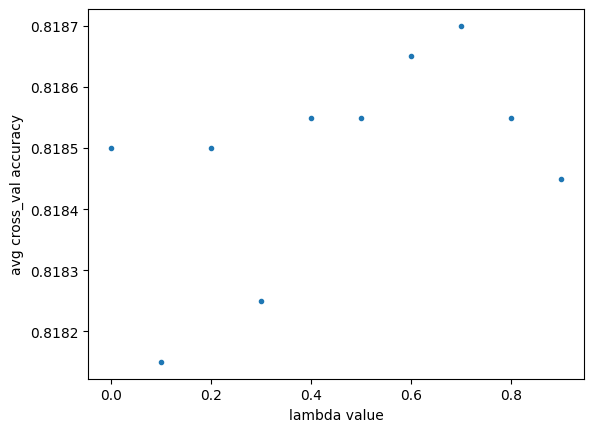

In [47]:
plt.plot(np.arange(0,1,0.1),res, '.')
plt.xlabel('lambda value')
plt.ylabel('avg cross_val accuracy');